# Recommender System WBSFLIX

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

In [4]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
# convert timestamp into date
tags['date'] = tags['timestamp'].apply(lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d'))
tags.head()

,userId,movieId,tag,timestamp,date
0,2,60756,funny,1445714994,2015-10-24
1,2,60756,Highly quotable,1445714996,2015-10-24
2,2,60756,will ferrell,1445714992,2015-10-24
3,2,89774,Boxing story,1445715207,2015-10-24
4,2,89774,MMA,1445715200,2015-10-24


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [9]:
# creata a new column with the year of the movie

movies = movies.assign(year = movies['title'].str.extract(r'(\d{4})'))
movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


Density of the matrix, amount of filled cells that are not zero - high density wanted for recommender systems - means lots of data available
Sparsity, 1 - density, amount of zeros in the matrix - sparse matrixes have a high amount of zeros

In [10]:
#ratings.shape (100836, 4), no ratings with 0, there are only rated films in the dataset
ratings.query('rating == 0').shape

(0, 4)

In [11]:
# many films have only few ratings, the last (fourth) quartile has ratings from 9 to 329 so a threshold for taking ratings into account will be set to >= 9
ratings.groupby('movieId').agg(count_rating=('rating','count')).sort_values(by='count_rating', ascending=False).describe()

,count_rating
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [12]:
agg_ratings = ratings.groupby('movieId').agg(count_rating=('rating','count'),mean_rating=('rating','mean')).sort_values(by=['count_rating', 'mean_rating'], ascending = False).head(20)
agg_ratings

,count_rating,mean_rating
movieId,,
356,329,4.164134
318,317,4.429022
296,307,4.197068
593,279,4.161290
2571,278,4.192446
260,251,4.231076
480,238,3.750000
110,237,4.031646
589,224,3.970982


In [13]:
agg_ratings = agg_ratings.query('count_rating >= 9').sort_values(by=['mean_rating', 'count_rating'], ascending=False).assign(log_rating=agg_ratings['mean_rating']*np.log(agg_ratings['count_rating'])).head(50)#.describe()
agg_ratings.sort_values(by='log_rating', ascending=False).head(20)

,count_rating,mean_rating,log_rating
movieId,,,
318,317,4.429022,25.506303
356,329,4.164134,24.135560
296,307,4.197068,24.035972
2571,278,4.192446,23.593498
593,279,4.161290,23.433107
260,251,4.231076,23.378610
2959,218,4.272936,23.007602
527,220,4.225000,22.788076
1196,211,4.215640,22.561506


# Popularity Rating

Recommend movies based on their overall popularity/ranking in the dataset

In [14]:
# dictionary with the movie title for a given list of movie Ids
dictionary = movies.filter(['movieId', 'title']).drop_duplicates()

def item_to_movie_title(item_ids:list, dictionary=dictionary):
    """
    Returns a list of Movie titles for a given list of movie (item) Ids
    """
    return (
        dictionary
        .query('movieId == @item_ids')
        ['title'].tolist()
    )

In [15]:
# For the popularity rating we need a dense matrix, with onl

In [16]:
#Function to return the n most popular movies from the dataset
def popularity_rating_thresh(df,thresh,num):
    """
    returns the n (num) movies that were rated best, taking only into account the movies that have more then x (thresh) ratings
    calculates the mean of the movie ratings, for movies with thresh number of ratings and returns the movies with the highest ratings
    inputs:
        - df - dataframe with the rating data
        - thresh - threshold for minimum amount of ratings for a movie
        - num - number of movies returned
    outpur:
        - dataframe with the titles of the n best rated movies
    """

    return (
    df
        .groupby('movieId')
        .agg(count_rating=('rating','count'),mean_rating=('rating','mean'))
        .query('count_rating >= @thresh')
        .sort_values(by=['mean_rating'], ascending=False).head(num)
        .reset_index()
        ['movieId'].tolist()
    )

In [17]:
popularity_rating_thresh(ratings, 100, 5)

[318, 858, 2959, 1221, 48516]

In [18]:
def popularity_rating_thresh_log(df,thresh,num):
    """
    returns the n (num) movies that were rated best, taking only into account the movies that have more then x (thresh) ratings
    calculates the mean rating of a movie by multiplying it with the logarithmic weight of the number of ratings
    inputs:
        - df - dataframe with the rating data
        - thresh - threshold for minimum amount of ratings for a movie
        - num - number of movies returned
    output:
        - list with top num movie ids
    """
    return (
    df
        .groupby('movieId')
        .agg(count_rating=('rating','count'),mean_rating=('rating','mean'))
        .assign(log_rating=lambda x: x['mean_rating']*np.log(x['count_rating']))
        .query('count_rating >= @thresh')
        .sort_values(by=['log_rating'], ascending=False).head(num)
        .reset_index()
        ['movieId'].tolist()
    )

In [19]:
popularity_rating_thresh_log(ratings, 100, 5)

[318, 356, 296, 2571, 593]

In [20]:
item_to_movie_title(popularity_rating_thresh_log(ratings, 100, 5))


['Pulp Fiction (1994)',
 'Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)']

## Popularity Chatbot

In [21]:
print('Hi! I’m your personal recommender. Let me recommend you some all time favourites to watch. From how many films would you like to chosse from? Input a number from 1 to lets say 5.')
n = int(input('Enter a number:'))
recs = item_to_movie_title(popularity_rating_thresh_log(ratings, 100, n))
print(f'You should try one of those films: {recs}.')

Hi! I’m your personal recommender. Let me recommend you some all time favourites to watch. From how many films would you like to chosse from? Input a number from 1 to lets say 5.
You should try one of those films: ['Shawshank Redemption, The (1994)'].


# Item-based Collaborative Filtering

Show Semi-personalized Recommendations, based on the movie a user liked most, output the n most similar movies to that movie

In [22]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:


#function to get all of the ratings for the movies in a list and return a dataframe
#only needed when list of movie Ids is available
def get_ratings_for_movies(movies_list):
    return (
    ratings[ratings['movieId'].isin(movies_list)]  
    )

def get_sparse_matrix(df):
    return (
    df
        .filter(['userId','movieId','rating'])
        .pivot('userId', 'movieId', 'rating')
    )    

def get_movie_name(id_list):
    data = ratings.merge(movies,on='movieId')
    data = data[data['movieId'].isin(id_list)]['title'].unique()
        #.title
        #.tolist()
    return data

def find_movieid():
    """
    From a given title (moviename), find the closest movie title and return its id
    """    
    # ask for movie title input, change to lower case to avoid problems with capital letters anywhere in the input
    title = input('Please enter a movie title:').lower()
    # search for titles in the data that contain the title input and filter them out
    found_titles = (
        dictionary
            .assign(check = lambda x: x['title'].str.lower().str.contains(title))
            .query('check')
            .sort_values('title') # just to have the titels alphabetically
    )

    # if there are multiple matches ask the user which film he meant and only return the selected film

    if found_titles.shape[0] > 1:
        print('Which one of the following movies do you mean?')
        n_movie = 1
        movies_titles = found_titles['title'].tolist()
        for movie in movies_titles:
            print("\t" + movie + " [type " + str(n_movie) + "]")
            n_movie += 1
        # ask user about which movie he/she wants    
        n_movie = input()
        selected_title = movies_titles[int(n_movie) - 1]
        found_titles = found_titles.query('title == @selected_title')

    # if there is no movie with that title, return False
    elif found_titles.shape[0] == 0:
        print('No movies have been found.')
        return False

    print(f'Your selected movie is {found_titles["title"].values[0]}')
    return found_titles['movieId'].values[0]


In [24]:
find_movieid()

Which one of the following movies do you mean?
	Animatrix, The (2003) [type 1]
	Matrix Reloaded, The (2003) [type 2]
	Matrix Revolutions, The (2003) [type 3]
	Matrix, The (1999) [type 4]
Your selected movie is Matrix Reloaded, The (2003)


6365

In [25]:
matrix = get_sparse_matrix(ratings)
matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def item_based_filtering(movie_id,thresh,num):
    """
    returns the n (num) most similar movies for the most liked movie of a user for the most actual film (year)
    calculates the mean rating of a movie by multiplying it with the logarithmic weight of the number of ratings
    inputs:
        - movies - List of top user movies to be used as items to find movies with a high correlation
        - num - number of movies returned
    outpur:
        - dataframe with the titles of the n most similar movies for the topn best rated movies of the user
    """
    #use threshold to take only the movies with a certain number of ratings into account
    ratings_thresh = (
        ratings
        .groupby('movieId')
        .agg(count_rating=('rating','count'),mean_rating=('rating','mean'))
        .query('count_rating >= @thresh')
        .sort_values(by=['mean_rating'], ascending=False).reset_index()['movieId'].tolist()
    )
    # filter the ratings dataset based on the movies with number of rating above threshold
    ratings.query('movieId == @ratings_thresh')

    sparse_ratings = get_sparse_matrix(ratings)
    #user_sparse_ratings = sparse_ratings[sparse_ratings.columns.intersection(movies)]
    rec_movies = (
    sparse_ratings
        .corrwith(sparse_ratings[movie_id])
        #.corrwith(user_sparse_ratings)
        .sort_values(ascending=False)
        .index
        .tolist()[:num]
    ) 

    #corr = pd.DataFrame(rec_movies, columns=['Correlation'])
    #corr.sort_values('Correlation', ascending=False, inplace=True)

    return rec_movies

In [27]:
def item_based_chat_bot():
    print("Hi I'm your personel recommender. Tell me a film you've liked!")

    movie_id = find_movieid()

    recommendations = item_based_filtering(movie_id, 100, 5)
    movie_recs = get_movie_name(recommendations)
    print(f"You will probably like also these films {movie_recs}")

item_based_chat_bot()    

Hi I'm your personel recommender. Tell me a film you've liked!
Which one of the following movies do you mean?
	Animatrix, The (2003) [type 1]
	Matrix Reloaded, The (2003) [type 2]
	Matrix Revolutions, The (2003) [type 3]
	Matrix, The (1999) [type 4]


ValueError: invalid literal for int() with base 10: ''

In [ ]:
ratings_thresh = (
        ratings
        .groupby('movieId')
        .agg(count_rating=('rating','count'),mean_rating=('rating','mean'))
        .query('count_rating >= 100')
        .sort_values(by=['mean_rating'], ascending=False).reset_index()['movieId'].tolist()
    )

ratings.query('movieId == @ratings_thresh')

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
7,1,110,4.0,964982176
...,...,...,...,...
100217,610,48516,5.0,1479542152
100310,610,58559,4.5,1493844688
100326,610,60069,4.5,1493844866
100380,610,68954,3.5,1493844881


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [114]:
find_movieid()

Your selected movie is Beautiful Mind, A (2001)


4995

# User-based Collaborative Filtering

We want to recommend a movie to a user based on the similarity between users and which movies they liked.

The cosine similarity can help us here to calculate the similarity between users. 

$$cosine\ similarity = 1 - cosine\ distance$$

The cosine distance is 0 when two items are very similar and it is 1 when they are very far away (not similar). To use it as a metric we can substract it from 1 to have values closer to 1 that show high similarity and values closer to 0 to show less similarity.

When we know similar users we can look at their movie ratings and predict ratings for missing movie ratings for our user. To keep it simple I will predict the ratings for not rated movies only for one user and not for all the users.

In [ ]:
# tranform the ratings into a sparse matrix for distance calculation
# and fill the missing values with 0, as missing values are not accepted in the cosine_distance function
ratings_sparse = get_sparse_matrix(ratings)
#ratings_sparse.fillna(value=0,inplace=True)
ratings_sparse.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list_zeros = []

for column in ratings_sparse:
       # Select column contents by column name using [] operator
       zeros = ratings_sparse[column].isna().sum()
       list_zeros.append(zeros)

filtered = []

for score in list_zeros:
    if score >= 600:
        filtered.append(score)

print(len(filtered))   

7603


In [ ]:
#ratings_sparse.columns[ratings_sparse.isnull().mean() < 0.98]

In [ ]:
#ratings_sparse[ratings_sparse.columns[ratings_sparse.isnull().sum() < 600]]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaled_ratings = MinMaxScaler().fit_transform(ratings_sparse)
scaled_ratings = pd.DataFrame(scaled_ratings)
scaled_ratings.fillna(value=0,inplace=True)
scaled_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.777778,0.0,0.777778,0.0,0.0,0.75,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.777778,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# calculate the cosine distances between all users
from sklearn.metrics.pairwise import cosine_distances
#user_distance = pd.DataFrame(cosine_distances(scaled_ratings), columns=scaled_ratings.index, index=scaled_ratings.index)
user_distance = pd.DataFrame(cosine_distances(ratings_sparse), columns=ratings_sparse.index, index=ratings_sparse.index)
user_distance.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.972717,0.940280,0.805605,0.870920,0.871848,0.841256,0.863032,0.935737,0.983125,...,0.919446,0.835545,0.778514,0.929331,0.846375,0.835809,0.730611,0.708903,0.906428,0.854679
2,0.972717,0.000000,1.000000,0.996274,0.983386,0.974667,0.972415,0.972743,1.000000,0.932555,...,0.797329,0.983134,0.988003,1.000000,1.000000,0.971571,0.987052,0.953789,0.972435,0.897573
3,0.940280,1.000000,0.000000,0.997749,0.994980,0.996064,1.000000,0.995059,1.000000,1.000000,...,0.994952,0.995108,0.975008,1.000000,0.989306,0.987007,0.980753,0.978872,1.000000,0.967881
4,0.805605,0.996274,0.997749,0.000000,0.871341,0.911509,0.884880,0.937031,0.988639,0.968837,...,0.914062,0.871727,0.692027,0.947015,0.915416,0.799605,0.868254,0.850142,0.967802,0.892317
5,0.870920,0.983386,0.994980,0.871341,0.000000,0.699651,0.891658,0.570925,1.000000,0.969389,...,0.931952,0.581253,0.889852,0.741227,0.851242,0.893565,0.847134,0.864465,0.738768,0.939208


In [ ]:
# calculate the cosine similarity (1 - cosine distance) for all users
#user_similarity = pd.DataFrame(1 - cosine_distances(scaled_ratings), columns=scaled_ratings.index, index=scaled_ratings.index)
user_similarity = pd.DataFrame(1 - cosine_distances(ratings_sparse), columns=ratings_sparse.index, index=ratings_sparse.index)
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

ratings_sparse.fillna(value=0,inplace=True)
similarities = pd.DataFrame(cosine_similarity(ratings_sparse), columns=ratings_sparse.index, index=ratings_sparse.index)
similarities.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


In [ ]:
def most_similar_users(similarity_matrix, user):
    #returns most similar users for a given user (userIduser
    return similarity_matrix[user].sort_values(ascending=False)

In [ ]:
most_similar_users(user_similarity,5).head(15)#.index

userId
5      1.000000
470    0.520671
229    0.517333
565    0.511325
235    0.507638
142    0.474124
476    0.453262
512    0.453101
58     0.452609
379    0.452029
468    0.446811
117    0.445072
126    0.438073
455    0.434493
46     0.430610
Name: 5, dtype: float64

In [ ]:
weighted_ratings = sum(ratings_sparse[10] * user_similarity[5])
weighted_ratings

91.98633749961064

In [ ]:
sum(user_similarity[5]) - 1

74.64668843550743

In [ ]:
round(weighted_ratings / (sum(user_similarity[5]) - 1))

1

In [ ]:
movies.query('movieId == 10')

,movieId,title,genres,year
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995


In [ ]:
movies.merge(ratings, on='movieId').query('movieId == 10 & (userId == 470 | userId ==229 | userId == 235 | userId == 476 | userId == 117)').sort_values(by='userId', ascending=False)

,movieId,title,genres,year,userId,rating,timestamp
714,10,GoldenEye (1995),Action|Adventure|Thriller,1995,476,3.0,835021420
713,10,GoldenEye (1995),Action|Adventure|Thriller,1995,470,3.0,849075144
662,10,GoldenEye (1995),Action|Adventure|Thriller,1995,235,2.0,841422389
660,10,GoldenEye (1995),Action|Adventure|Thriller,1995,229,4.0,836941790
637,10,GoldenEye (1995),Action|Adventure|Thriller,1995,117,3.0,844162850


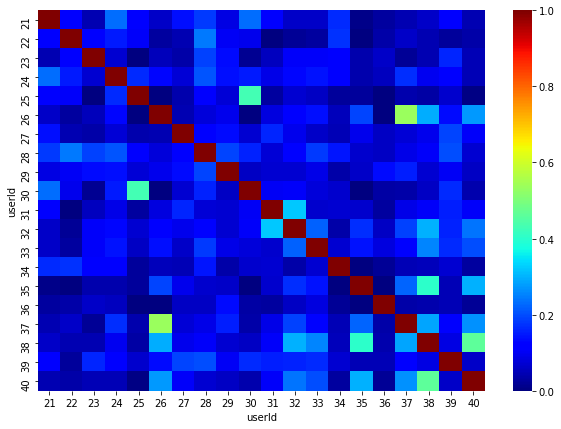

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(user_similarity.iloc[20:40,20:40], vmin=0, vmax=1, cmap="jet") #cmap="YlGnBu"

plt.show()

In [ ]:
np.percentile(user_similarity, 75, axis=1).max()

0.28307857699837013

In [ ]:
user_similarity[user_similarity > 0.5].count().sum() - 610 # -610 because these are the 1 values for the similarity of each user with himself

1704

In [ ]:
((user_similarity[user_similarity > 0.5].count().sum() - 610) /(610*610))*100

0.45794141359849505

## Model creation

### Split the ratings dataset into train and test data to be able to evaluate the model

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_creation(data, random_state=1, train_size=.8):
    """
    Given a ratings data, transform it into a sparse matrix and return
    a train, test, train_pos, test_pos (in that order)
    """
    # create the sparse matrix
    sparse_df = get_sparse_matrix(data)
    # locate all positions with a rating
    ratings_pos = pd.DataFrame(
        # find all the positions different than missing values
        # 1. transform the sparse matrix into a numpy array
        # 2. the ~ operator help us to define "not". If we combine it with 
        #   np.isnan we are saying "is not nan"
        # 3. np.argwhere help us to find the positions with the argument 
        #   we are looking for in an array. In that case is all the non 
        #   nan positions in our array
        np.argwhere(~np.isnan(np.array(sparse_df)))
    ) # np.argwhere(a) is almost the same as np.transpose(np.nonzero(a)), 
    # but produces a result of the correct shape for a 0D array.
    # Source: numpy documentation

    train_pos, test_pos = train_test_split(
        ratings_pos, random_state=random_state, train_size=train_size)

    # create an empty dataframe full of 0, with the same shape as the sparse_df data
    train = np.zeros(sparse_df.shape)
    # fill the set with the sparse_df ratings based on the train positions
    for pos in train_pos.values: 
        index = pos[0]
        col = pos[1]
        train[index, col] = sparse_df.iloc[index, col]
    train = pd.DataFrame(
        train, 
        columns=sparse_df.columns, 
        index=sparse_df.index
        )

    # now it is time for the test set. We will follow the same process
    test = np.zeros(sparse_df.shape)
    for pos in test_pos.values: 
        index = pos[0]
        col = pos[1]
        test[index, col] = sparse_df.iloc[index, col]
    test = pd.DataFrame(
        test, 
        columns=sparse_df.columns, 
        index=sparse_df.index
        )

    return train, test, train_pos, test_pos

rdy_rat = ratings.drop(columns='timestamp')
train, test, train_pos, test_pos = train_test_creation(rdy_rat)

### Find all user cosine similarities in the train sparsed data

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# train the model
train_similitudes = pd.DataFrame(
    cosine_similarity(train), 
    columns=train.index, index=train.index
    )

### Create Recommender

In [ ]:
def user_based_recommender(index_name, column_name, sim_df, sparse_df): 
    results = (
    pd.DataFrame({
        'ratings': sparse_df.loc[:,column_name], 
        'similitudes' : sim_df.loc[index_name,:].tolist()
    })
        .query('ratings != 0')
        .assign(weighted_ratings = lambda x: x.ratings * x.similitudes)
        .agg({
            'weighted_ratings':'sum', 
            'similitudes':'sum'
        })
    )
    pred_rating = (results['weighted_ratings'] / results['similitudes'])
    return pred_rating
# user_based_recommender(353, 6416, train_similitudes, test)

### Model evaluation

In [ ]:
def round_off_rating(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""
    return round(number * 2) / 2

predictions = [
    round_off_rating(
        user_based_recommender(
            test.index[pos[0]], test.columns[pos[1]], train_similitudes, test
            )
        ) 
    for pos in test_pos.values]
true_values = [test.iloc[pos[0],pos[1]] for pos in test_pos.values]


        MSE: 0.29694317731059106
        RMSE: 0.544924928142025
        MAE: 0.3507784609282031
        MAPE: 0.1473720548975904
        
Head() plot data:
   preds  true  count_perc
0    0.5   0.5  100.000000
1    1.0   0.5   25.000000
2    1.0   1.0   75.000000
3    1.5   0.5   14.626866
4    1.5   1.0   45.074627
5    1.5   1.5   35.522388
6    1.5   2.0    4.776119
7    2.0   0.5    5.529954
8    2.0   1.0   15.437788
9    2.0   1.5   11.290323


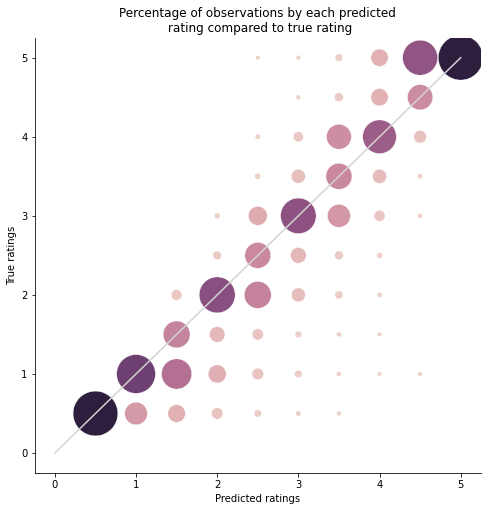

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def predictions_analysis(y_true, preds): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, preds)}
        RMSE: {mean_squared_error(y_true, preds)**0.5}
        MAE: {mean_absolute_error(y_true, preds)}
        MAPE: {mean_absolute_percentage_error(y_true, preds)}
        """
    )

    p_df = (
    pd.DataFrame({
        'preds':preds, 
        'true':y_true
        })
        .groupby(['preds','true'])['preds']
        .count()
        .groupby(level=0)
        .apply(lambda x: 100 * x / float(x.sum()))
        .reset_index(name='count_perc'))#.reset_index(name='count')
    print('Head() plot data:')
    print(p_df.head(10))
    plt.subplots(figsize=(8, 8))
    sns.scatterplot(
        data=p_df, x='preds',y='true', 
        size='count_perc', hue='count_perc', sizes=(20, 2000)
        )
    sns.lineplot(x=[0,5], y=[0,5], color='lightgrey')
    plt.title('Percentage of observations by each predicted\n rating compared to true rating')
    plt.xlabel('Predicted ratings')
    plt.ylabel('True ratings')
    plt.legend([],[], frameon=False)
    sns.despine()
    plt.show()

predictions_analysis(true_values, predictions)

### User-based recommender 

In [ ]:
import sys
def get_user_based_recommendations(data, user, top_n=5):
    """
    Given the rating data and a user id, return the top n films

    FURTHER IMPROVEMENT: 
    * Increase the performance by excluding all the films with a low
    number of ratings. An option would be to combine the popular and user-based recommender.
    """
    # get the sparse matrix
    sparse_df = get_sparse_matrix(data).replace(np.nan, 0)
    if user not in sparse_df.index: 
        print('User not found!')
        return False
    # calculate the similitude matrx with cosine strategy
    similitudes_df = pd.DataFrame(
        cosine_similarity(sparse_df), 
        columns=sparse_df.index, index=sparse_df.index
        )
    # find out the non rated movies by our user
    non_rated_movies = (
        sparse_df
        .loc[user, :]
        .reset_index(name='user_rating')
        .query('user_rating == 0')
        )
    # find the predictied for each non rated film
    # display a nice progress bar to know how the process is going
    pred_rat = []
    i = 0
    n=len(non_rated_movies['movieId'])
    for item in non_rated_movies['movieId'].tolist():
        pred_rat.append(
            user_based_recommender(user, item, similitudes_df, sparse_df)
            )
        # progress bar
        sys.stdout.write('\r')
        j = (i + 1) / n
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()
        i+=1
    # add the predicted ratings and sort them
    top_pred_ratings = (
    non_rated_movies
        .assign(pred = pred_rat)
        .sort_values('pred', ascending=False)
        .head(top_n)
        )
    # return a list of the movies id with a higer predicted rating
    return top_pred_ratings['movieId'].tolist()

# recommendations = get_user_based_recommendations(rdy_rat, 70)
# item_to_movie_title(recommendations)

### Chatbot User-based Recommender

In [ ]:
def user_based_chat_bot(): 
    print("Hi! I'm your personal recommender. Can you remember me your user id?")
    # help user to find the movie name
    user_id = int(input())
    # find out the most correlated films to the given movie id
    print('Based on your previous ratings, let me recommend you one film!')
    recommendations = get_user_based_recommendations(
        ratings.drop(columns='timestamp'), 
        user=user_id,
        top_n=1)
    if not recommendations: 
        return
    # get top movie title
    recommended_movie = item_to_movie_title(recommendations)[0]
    print(f"\nYou will probably like {recommended_movie}")
    
user_based_chat_bot()

Hi! I'm your personal recommender. Can you remember me your user id?
Based on your previous ratings, let me recommend you one film!
[====================] 100%
You will probably like Justice League: Doom (2012) 


In [ ]:
movies.sample(5)

,movieId,title,genres,year
7291,75803,Our Family Wedding (2010),Comedy,2010
442,507,"Perfect World, A (1993)",Crime|Drama|Thriller,1993
2051,2730,Barry Lyndon (1975),Drama|Romance|War,1975
6485,53024,Jonestown: The Life and Death of Peoples Templ...,Documentary,2006
3166,4260,"Visit, The (2000)",Drama,2000
